In [1]:
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf
import torch

REPO_PATH = "/users/gabrijel/projects/vfmf/"  # adjust this
CKPTS_PATH = "/work/gabrijel/vfmf-checkpoints"  # adjust this

## Configuration

In [2]:
CONFIG_PATH = f"{REPO_PATH}/world-model/configs/cityscapes"
CONFIG_NAME = "dino_foresight_cfm_4x_accum_4x_wandb_latent_variable_length_large_vae.yaml"
CKPT_PATH = f"{CKPTS_PATH}/world-model/cityscapes/vae/raw_convnext_isotropic_large(VAE, beta=0.01)/epoch=3200.pt"

WEIGHTS = "ema"
BETA = "0.01"
DEVICE = torch.device("cuda:0")

RGB_DECODER_CONFIG = f"{REPO_PATH}/vae/configs"
RGB_DECODER_NAME = "default_raw_cityscapes_rgb_vae"
RGB_DECODER_CKPT = f"{CKPTS_PATH}/rgb/cityscapes/dino_foresight_vit_base_rgb_decoder(vae)/best.pt"

SEG_CKPT = f"{CKPTS_PATH}/heads/cityscapes/train_cityscapes_224_448_vae_large_l[2,_5,_8,_11]_segm_head_batch_size=128/lightning_logs/version_0/checkpoints/epoch=41-step=1008.ckpt"
DEPTH_CKPT = f"{CKPTS_PATH}/heads/cityscapes/train_cityscapes_224_448_vae_large_l[2,_5,_8,_11]_depth_head_batch_size=128/lightning_logs/version_0/checkpoints/epoch=41-step=1008.ckpt"
NORMALS_CKPT = f"{CKPTS_PATH}/heads/cityscapes/train_cityscapes_224_448_vae_large_l[2,_5,_8,_11]_normals_head_batch_size=128/lightning_logs/version_0/checkpoints/epoch=92-step=2232.ckpt"

# seeds = [0,1,7,17,42]
seeds = [0, 1, 7]

horizon = 24
sampling_steps = 10
sampling_method = "euler"
context_length = 2  # adjust this, valid values are: 1, 2, 3, 4

config_name_no_ext = CONFIG_NAME

with initialize_config_dir(config_dir=CONFIG_PATH, version_base=None):
    cfg = compose(
        config_name=config_name_no_ext,
        overrides=[
            f"vae.model.beta={BETA}",
        ],
    )
    cfg.vae.ckpt_path = f"{CKPTS_PATH}/vae/cityscapes/{cfg.vae.name}/checkpoints/best.pt"
    cfg.vae.latent_dist_stats_path = f"{CKPTS_PATH}/feature_stats/cityscapes/lowres/{cfg.vae.name}.npz"
    cfg.vae.model.feature_stats = f"{CKPTS_PATH}/feature_stats/cityscapes/lowres/dino.npz"
    VAE_NAME = cfg.vae.name

print(OmegaConf.to_yaml(cfg))

model:
  sequence_length: 5
  img_size:
  - 224
  - 448
  patch_size: 14
  separable_attention: true
  separable_window_size: 1
  layers: 12
  heads: 8
  hidden_dim: 1152
  dropout: 0.1
vae:
  objective: VAE
  name: ${vae.model.name}(${vae.objective}, beta=${vae.model.beta})
  model:
    name: raw_convnext_isotropic_large
    dinov2_variant: vitb14_reg
    feature_stats: /work/gabrijel/vfmf-checkpoints/feature_stats/cityscapes/lowres/dino.npz
    intermediate_layers:
    - 2
    - 5
    - 8
    - 11
    patch_size: 14
    input_dim: 3072
    depth: 36
    dim: 1024
    latent_channels: 16
    drop_path_rate: 0
    layer_scale_init_value: 0
    shape:
    - 16
    - 32
    beta: 0.01
  ckpt_path: /work/gabrijel/vfmf-checkpoints/vae/cityscapes/raw_convnext_isotropic_large(VAE,
    beta=0.01)/checkpoints/best.pt
  latent_dist_stats_path: /work/gabrijel/vfmf-checkpoints/feature_stats/cityscapes/lowres/raw_convnext_isotropic_large(VAE,
    beta=0.01).npz
training:
  wandb: true
  seed: 123


## Load the pipeline

In [3]:
from typing import Literal
from omegaconf import DictConfig
from torchinfo import summary


def load_denoiser(
    cfg: DictConfig,
    ckpt_path: str,
    weights: Literal["model", "ema"] = "ema",
    device: torch.device = torch.device("cpu")
):
    from models.autoregressive_dino_foresight_latent import AutoregressiveDINOForesightLatent

    denoiser = AutoregressiveDINOForesightLatent(**cfg.model, vae=cfg.vae)
    ckpt = torch.load(
        ckpt_path,
        map_location="cpu",
        weights_only=False
    )
    denoiser.load_state_dict(ckpt[f"{weights}_state_dict"])
    denoiser = denoiser.to(device)
    denoiser.eval()

    return denoiser


def load_rgb_decoder(
    decoder_config_dir: str,
    decoder_config_name: str,
    decoder_ckpt: str,
    device: torch.device
):
    from models.dino_rgb_decoder import DINORGBDecoder

    with initialize_config_dir(
        config_dir=decoder_config_dir,
        version_base=None
    ):
        cfg = compose(config_name=decoder_config_name)
        cfg.model.feature_stats = f"{CKPTS_PATH}/feature_stats/cityscapes/lowres/dino.npz"
        cfg.vae_config_path = f"{CONFIG_PATH}/vae/raw/convnext_isotropic_large.yaml"
        cfg.vae_ckpt_path = f"{CKPTS_PATH}/vae/cityscapes/{VAE_NAME}/checkpoints/best.pt"

    rgb_decoder = DINORGBDecoder(**cfg.model)
    ckpt = torch.load(
        decoder_ckpt,
        map_location=device
    )
    rgb_decoder.load_state_dict(ckpt["model_state_dict"])
    rgb_decoder = rgb_decoder.to(device)
    _ = rgb_decoder.eval()

    return rgb_decoder

In [4]:
denoiser = load_denoiser(cfg, CKPT_PATH, WEIGHTS, DEVICE)
summary(denoiser)

/users/gabrijel/miniconda3/envs/dino_foresight/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in /users/gabrijel/.cache/torch/hub/facebookresearch_dinov2_main
/users/gabrijel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/users/gabrijel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/users/gabrijel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Layer (type:depth-idx)                                  Param #
AutoregressiveDINOForesightLatent                       --
├─DINORawVAE: 1-1                                       --
│    └─DinoVisionTransformer: 2-1                       1,056,768
│    │    └─PatchEmbed: 3-1                             (452,352)
│    │    └─ModuleList: 3-2                             (85,072,896)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Identity: 3-4                               --
│    └─ConvNeXtIsotropicVAE: 2-2                        --
│    │    └─ConvNeXtIsotropic: 3-5                      (307,237,888)
│    │    └─LayerNorm: 3-6                              (2,048)
│    │    └─Linear: 3-7                                 (32,800)
│    │    └─Linear: 3-8                                 (17,408)
│    │    └─ConvNeXtIsotropic: 3-9                      (305,140,736)
│    │    └─Linear: 3-10                                (3,148,800)
├─MaskTransformer: 1-2           

In [5]:
rgb_decoder = load_rgb_decoder(
    RGB_DECODER_CONFIG,
    RGB_DECODER_NAME,
    RGB_DECODER_CKPT,
    DEVICE
)
summary(rgb_decoder)

Using cache found in /users/gabrijel/.cache/torch/hub/facebookresearch_dinov2_main


Layer (type:depth-idx)                             Param #
DINORGBDecoder                                     --
├─DinoVisionTransformer: 1-1                       1,056,768
│    └─PatchEmbed: 2-1                             --
│    │    └─Conv2d: 3-1                            (452,352)
│    │    └─Identity: 3-2                          --
│    └─ModuleList: 2-2                             --
│    │    └─NestedTensorBlock: 3-3                 (7,089,408)
│    │    └─NestedTensorBlock: 3-4                 (7,089,408)
│    │    └─NestedTensorBlock: 3-5                 (7,089,408)
│    │    └─NestedTensorBlock: 3-6                 (7,089,408)
│    │    └─NestedTensorBlock: 3-7                 (7,089,408)
│    │    └─NestedTensorBlock: 3-8                 (7,089,408)
│    │    └─NestedTensorBlock: 3-9                 (7,089,408)
│    │    └─NestedTensorBlock: 3-10                (7,089,408)
│    │    └─NestedTensorBlock: 3-11                (7,089,408)
│    │    └─NestedTensorBlock: 3-12 

In [6]:
from decoder import ModalitiesDecoder

modalities_decoder = ModalitiesDecoder(
    fg_bg_ckpt={},
    segm_ckpt=SEG_CKPT,
    depth_ckpt=DEPTH_CKPT,
    normals_ckpt=NORMALS_CKPT,
    image_size=(224, 448),
    resize_size=(224, 448),
    embed_dim=768,
    dpt_num_features=256,
    dpt_use_bn=True,
    dpt_out_channels=[128, 256, 512, 512],
    dpt_use_clstoken=False,
    dpt_layers=[2, 5, 8, 11],
    num_segm_classes=19
)
modalities_decoder = modalities_decoder.to(DEVICE)
summary(modalities_decoder)

Layer (type:depth-idx)                                  Param #
ModalitiesDecoder                                       --
├─ModalityDecoder: 1-1                                  --
│    └─DPTHead: 2-1                                     --
│    │    └─ModuleList: 3-1                             1,082,752
│    │    └─ModuleList: 3-2                             2,884,480
│    │    └─Module: 3-3                                 13,551,891
├─ModalityDecoder: 1-2                                  --
│    └─DPTHead: 2-2                                     --
│    │    └─ModuleList: 3-4                             1,082,752
│    │    └─ModuleList: 3-5                             2,884,480
│    │    └─Module: 3-6                                 13,612,800
├─ModalityDecoder: 1-3                                  --
│    └─DPTHead: 2-3                                     --
│    │    └─ModuleList: 3-7                             1,082,752
│    │    └─ModuleList: 3-8                             2,8

## Sampling

In [7]:

from typing import List, Optional
from models.autoregressive_dino_foresight_latent import AutoregressiveDINOForesightLatent
from sample_benchmark import sample_autoregressive
from seed import seed_everything
from tqdm.auto import tqdm


def sample(
    denoiser: AutoregressiveDINOForesightLatent,
    rgb_ctx: torch.Tensor,
    seeds: List[int],
    sampling_steps: int,
    sampling_method: str,
    device: torch.device,
    num_rollouts: Optional[int] = None,
) -> List[torch.Tensor]:
    _, context_length, *_ = rgb_ctx.shape

    f_preds: List[torch.Tensor] = []
    f_ctx: torch.Tensor = denoiser.vae.postprocess(
        denoiser.vae.preprocess(rgb_ctx)
    )

    for seed in tqdm(seeds):
        seed_everything(seed)

        if num_rollouts is None:
            if "cityscapes" in cfg.data.dataset_root:
                num_rollouts = 9 - (context_length - 1)
            else:
                num_rollouts = 11 - (context_length - 1)

        max_context_length = 4
        f_pred = sample_autoregressive(
            denoiser,
            f_ctx,
            num_rollouts,
            max_context_length,
            sampling_steps,
            sampling_method,
            rng=torch.Generator(device).manual_seed(seed)
        )
        f_preds.append(f_pred)

    return f_preds

## Dataset

In [8]:
from torch.utils.data import Dataset
from pathlib import Path
import cv2
from PIL import Image
from typing import TypedDict, List, Any
from pathlib import Path
from torch.utils.data import Dataset
from PIL import Image


def load_mp4_as_pil(path):
    cap = cv2.VideoCapture(path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(Image.fromarray(frame))

    cap.release()
    return frames


# 1. Define the TypedDict
class CityscapesSample(TypedDict):
    context_rgb: List[Image.Image]
    context_segm: List[Image.Image]
    context_depth: List[Image.Image]
    context_normal: List[Image.Image]


class CityscapesDemoDataset(Dataset):
    def __init__(self, root_dir: Path, context_length: int):
        self.scenes = list(
            sorted(
                root_dir.iterdir()
            )
        )
        self.context_length = context_length

    def __len__(self) -> int:
        return len(self.scenes)

    # 2. Update the return type annotation and the return statement
    def __getitem__(self, idx) -> CityscapesSample:
        scene = self.scenes[idx]

        # Load data
        rgbs = load_mp4_as_pil(scene / "f_ctx.mp4")[:self.context_length]
        depth = load_mp4_as_pil(
            scene / "f_ctx_depth.mp4")[:self.context_length]
        segmentation = load_mp4_as_pil(
            scene / "f_ctx_segmentation.mp4")[:self.context_length]
        normals = load_mp4_as_pil(
            scene / "f_ctx_surface_normals.mp4")[:self.context_length]

        # Return the TypedDict
        return {
            "context_rgb": rgbs,
            "context_segm": segmentation,
            "context_depth": depth,
            "context_normal": normals
        }

In [9]:
dataset = CityscapesDemoDataset(
    root_dir=Path(f"{REPO_PATH}/world-model/demos/cityscapes"),
    context_length=context_length
)  # type: ignore

In [10]:
from transforms import transform_validation

preprocess = transform_validation(
    (224, 448),
    dinov2=True,
    convert_to_rgb=True
)

Preview demo examples.


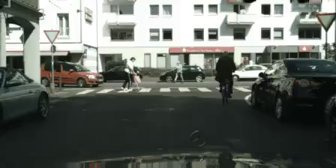
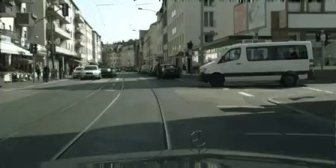
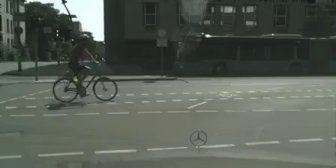
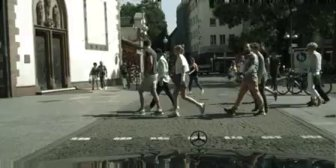
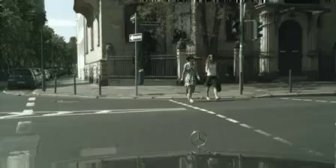
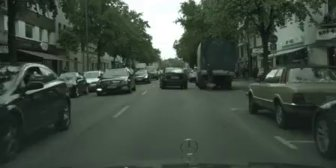
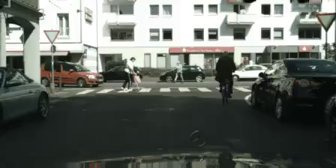
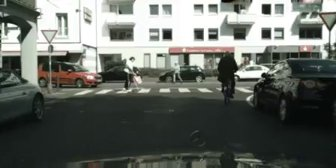
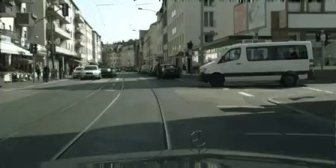
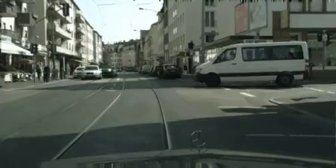
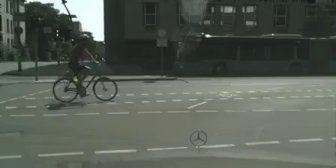
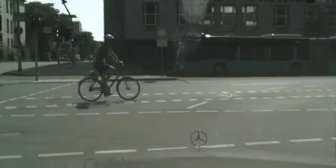
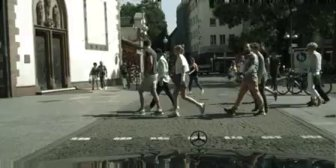
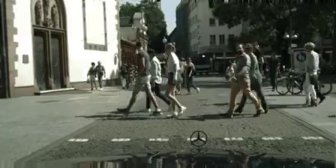
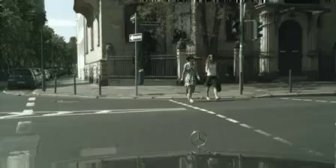
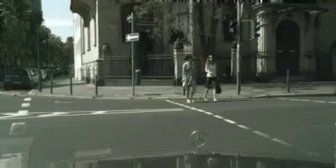
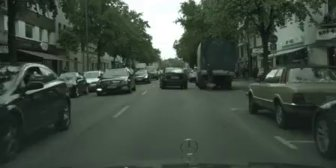
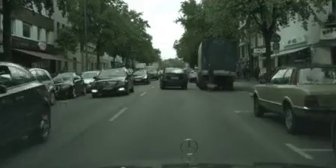

In [11]:
from einops import rearrange
from notebook_utils import display_context_animations
from transforms import denormalize_dino


display_context_animations(
    [
        dataset[index]['context_rgb']
        for index in range(6)
    ],
    max_frames=4,
    fps=5,
    scale=0.75
)

In [12]:
dataset_index = 5  # adjust it here

In [13]:
rgb_ctx_preprocessed = (
    preprocess(
        dataset[dataset_index]["context_rgb"]
    ).to(DEVICE)
)[None]

Sample.

In [14]:
f_preds = sample(
    denoiser,
    rgb_ctx_preprocessed,
    seeds,
    sampling_steps,
    sampling_method,
    DEVICE
)

  0%|          | 0/3 [00:00<?, ?it/s]

[sampling steps]: 10
[context length]: 2
[context length]: 3
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[sampling steps]: 10
[context length]: 2
[context length]: 3
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[sampling steps]: 10
[context length]: 2
[context length]: 3
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4


## Samples

Decode features.

In [15]:
from PIL import Image
from einops import rearrange
from visualization import depth_to_image, normals_to_image, segs_to_image, decode_rgb

example_idx = 0

sample_segs: List[List[Image.Image]] = []
sample_depths: List[List[Image.Image]] = []
sample_normals: List[List[Image.Image]] = []
sample_rgbs: List[List[Image.Image]] = []

context_rgbs = dataset[dataset_index]['context_rgb']
context_segm = dataset[dataset_index]['context_segm']
context_depths = dataset[dataset_index]['context_depth']
context_normals = dataset[dataset_index]['context_normal']


for f_pred in f_preds:
    out = modalities_decoder(f_pred)

    segs: List[Image.Image] = []
    depths: List[Image.Image] = []
    normals: List[Image.Image] = []
    rgbs: List[Image.Image] = []

    for segm in out['segm']['labels'][example_idx]:
        segs.append(segs_to_image(segm, colormap_name="cityscapes"))
    for depth in out['depth']['labels'][example_idx]:
        depths.append(depth_to_image(depth))
    for norm in out['surface_normals']['preds'][example_idx]:
        normals.append(normals_to_image(norm))

    sample_segs.append(segs)
    sample_depths.append(depths)
    sample_normals.append(normals)
    sample_rgbs.append(
        decode_rgb(
            rgb_decoder,
            rearrange(f_pred, "b t h w c -> t b h w c"),
            DEVICE
        )
    )

Display decoded modalities.


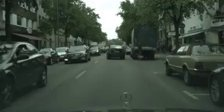
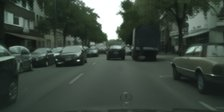
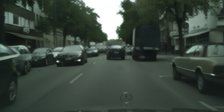
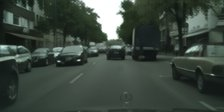
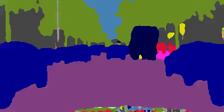
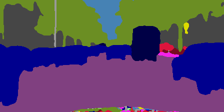
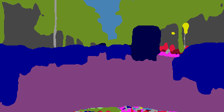
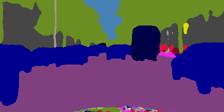
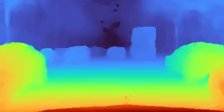
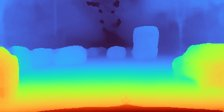
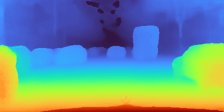
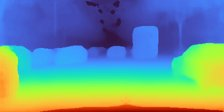
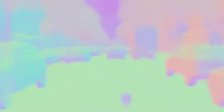
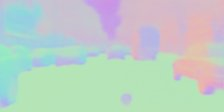
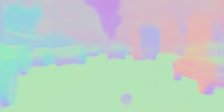
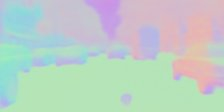
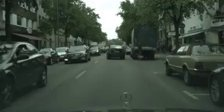
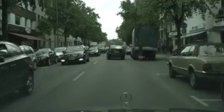
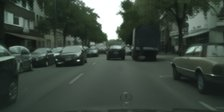
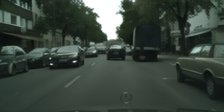
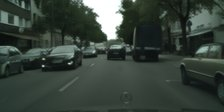
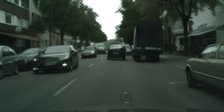
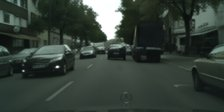
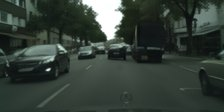
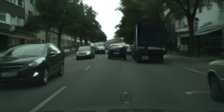
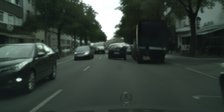
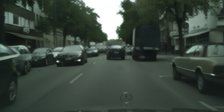
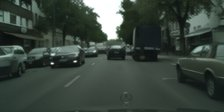
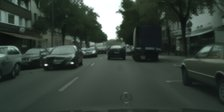
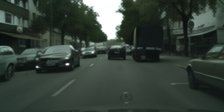
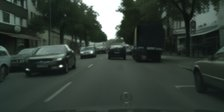
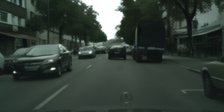
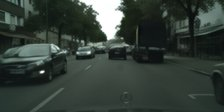
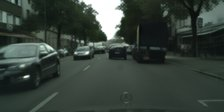
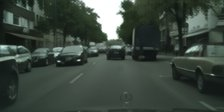
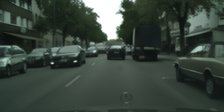
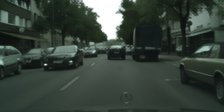
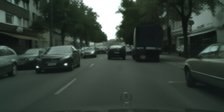
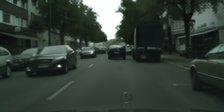
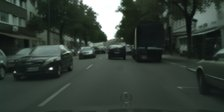
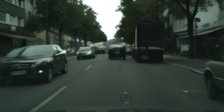
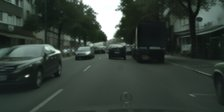
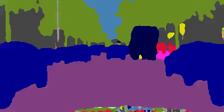
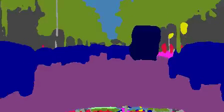
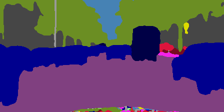
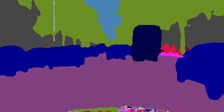
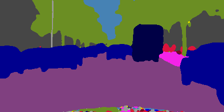
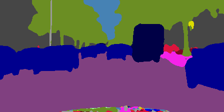
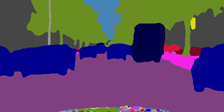
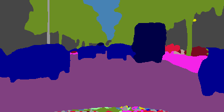
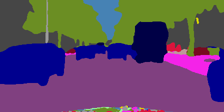
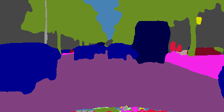
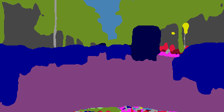
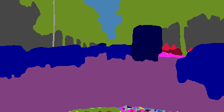
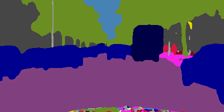
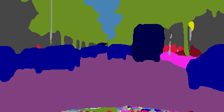
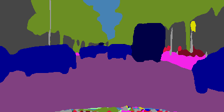
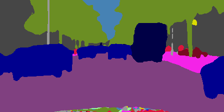
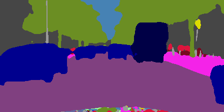
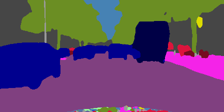
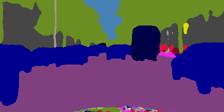
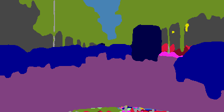
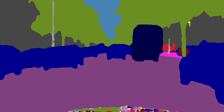
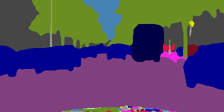
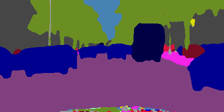
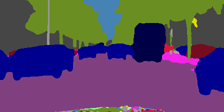
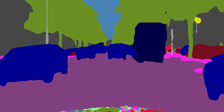
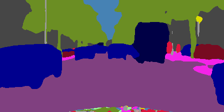
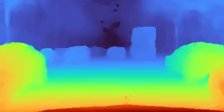
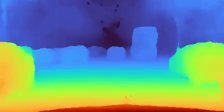
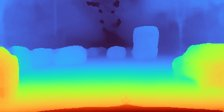
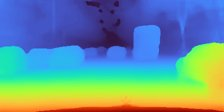
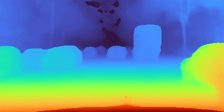
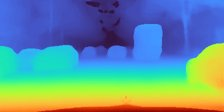
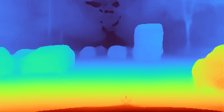
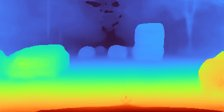
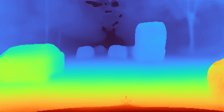
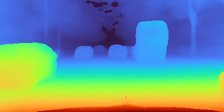
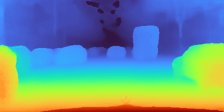
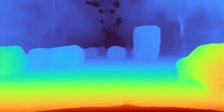
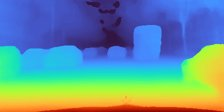
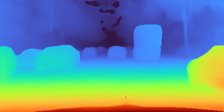
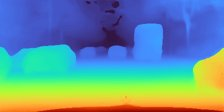
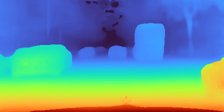
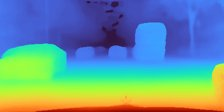
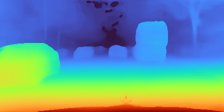
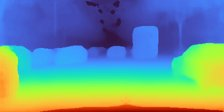
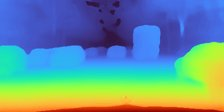
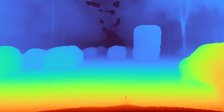
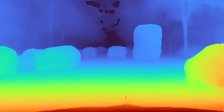
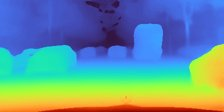
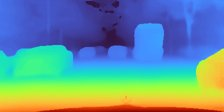
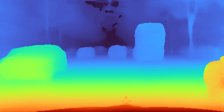
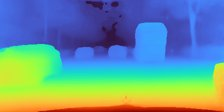
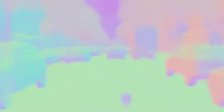
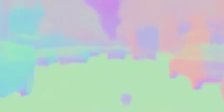
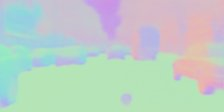
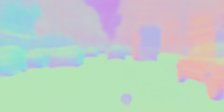
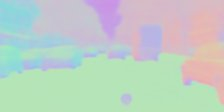
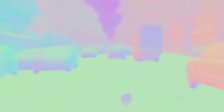
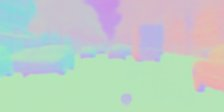
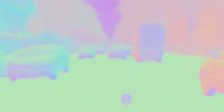
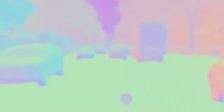
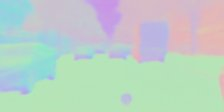
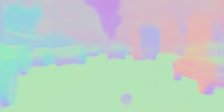
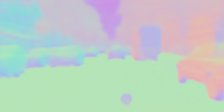
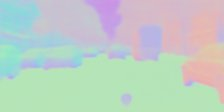
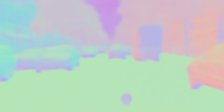
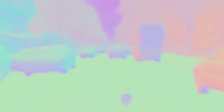
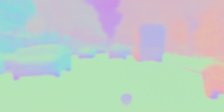
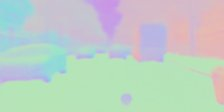
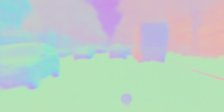
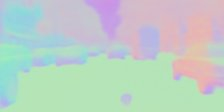
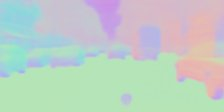
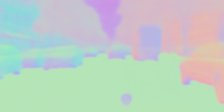
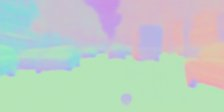
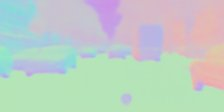
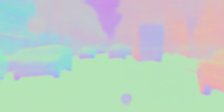
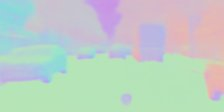
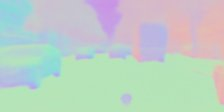

: 

In [ ]:

from notebook_utils import display_controllable_grid


display_controllable_grid(
    seeds=seeds,
    sample_rgbs=sample_rgbs,
    sample_segs=sample_segs,
    sample_depths=sample_depths,
    sample_normals=sample_normals,
    context_rgbs=context_rgbs,
    context_segs=context_segm,
    context_depths=context_depths,
    context_normals=context_normals,
    base_duration=67,
    scale=0.5,
    cell_width=448,
    cell_height=224
)